In [1]:
def get_dset_ready(path, batch_index, read_limit):
    batch,v = get_map_ids_vocab(path, batch_index=batch_index)
    pos_dset = get_dset(list(batch.values()),list(batch.keys()),v, read_limit)
    return pos_dset, batch

In [2]:
def plot_exp(path, kmer, limit, batch_index):
    pos_dset = get_dset_ready(path, batch_index)
    plot_dset(pos_dset, kmer, limit=limit, batch=batch)
    

In [3]:
from taiyaki.mapped_signal_files import HDF5Reader
def get_map_ids_vocab(hdf5_reader_path, batch_index):
    reader = HDF5Reader(hdf5_reader_path)
    nums = reader.get_alphabet_information().collapse_labels
    letters = list(reader.get_alphabet_information().collapse_alphabet)
    vocab_map = {x:y for (x,y) in zip(nums,letters)}
    batch = reader._load_reads_batch(reader.batch_names[batch_index])
    # signal_mappings = list(batch.values())
    # read_ids = list(batch.keys())
    return (batch, vocab_map)

In [4]:
import numpy as np
def process_signal_mapping(mapping):
    #Taken from RODAN code
    signal = (mapping.Dacs + mapping.offset) * mapping.range / mapping.digitisation
    med = np.median(signal)
    mad = mapping.offset * np.median(abs(signal-med))
    signal = (signal - mapping.shift_frompA) / mapping.scale_frompA
    return signal
    

In [5]:


#TODO get_current method of signal mapping normalizes data!!!!!!!!!!!!!!!!!!!!!!

In [6]:
from matplotlib import pyplot as plt

def update_dataset(dataset, mapping, readid, vocab_map):
    signal = process_signal_mapping(mapping)
    letter_reference = [vocab_map[num] for num in mapping.Reference]
    ranges = [(mapping.Ref_to_signal[i], mapping.Ref_to_signal[i+1]) for i in range(len(mapping.Ref_to_signal)-1)]
    # for i in range(len(letter_reference)-4):
        # print(''.join(letter_reference[i:i+5]))
    letter_to_ref = list(zip(letter_reference, ranges))
    for i in range(len(letter_to_ref)-4):
        #TODO filter too long/short bases
        seq = ''
        bases_lengths = []
        for j in range(5):
            letter, interval = letter_to_ref[i+j]
            bases_lengths.append(interval[1] - interval[0])
            if(j == 0):
                start = interval[0]
            if(j == 4):
                end = interval[1]
            seq+=letter
        
        #TODO batch number log?
        # item = {'start':start, 'end':end, 'read_id':readid}
        if(seq not in dataset.keys()):
            dataset[seq] = [(start,end, readid)]
        else:
            dataset[seq].append((start,end, readid))
        # plt.plot(signal[start:end])
        # break
        
def get_dset(signal_mappings, read_ids, vocab_map, read_limit):
    dset = {}
    for i in range(read_limit):
        update_dataset(dset, signal_mappings[i], read_ids[i], vocab_map)
    return dset


def plot_dset(dset, kmer, limit, batch):
    targets = dset[kmer]
    for start, stop, readid in targets[:limit]:
        window = process_signal_mapping(batch[readid])[start: stop]
        plt.plot(window)
        plt.show()


In [7]:
# mapping = random.choice(self.batch_mappings)

# signal = self.process_signal_mapping(mapping)

# #TODO add skip parameter instead of 0
# last_start_index = len(signal)-self.window
# #Using torch rand becasue of multiple workers
# start = torch.randint(0, last_start_index+1, (1,))
# end = start+self.window

# window_positions = (start,end)
# ref_beg, ref_end = np.searchsorted(mapping.Ref_to_signal, window_positions)
# bases_count  = ref_end-ref_beg
# window_ref = mapping.Reference[ref_beg:ref_end]

# #TODO how rodan limits data? base_len > smth etc...
# is_ok = (len(window_ref) == bases_count) and bases_count > 0
# event = signal[start:end]
# sequence = [self.vocab_map_reversed[index] for index in window_ref]

In [36]:
from tslearn.utils import to_time_series_dataset
import numpy as np
from itertools import repeat
from scipy.signal import resample


def get_tslearn_dset(path_pos, path_neg, batch_index, read_limit, kmer):
    pos_dset, pos_batch = get_dset_ready(path_pos, batch_index, read_limit)
    neg_dset, neg_batch = get_dset_ready(path_neg, batch_index, read_limit)
    pos_data = [process_signal_mapping(pos_batch[r_id])[s:e] for s,e,r_id in pos_dset[kmer]]
    neg_data = [process_signal_mapping(neg_batch[r_id])[s:e] for s,e,r_id in neg_dset[kmer]]

    all_data = pos_data+neg_data
    
    resampling_len = 100
    #throwing away length information with resampling!!!
    all_data = [resample(sig, resampling_len) for sig in all_data]

    X = to_time_series_dataset(all_data)
    y = list(repeat(1,len(pos_data)))+list(repeat(0,len(neg_data)))
    return X,y

In [107]:
path_neg = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_0'
path_pos = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_33'
kmer = 'CGAGG'
train_X, train_y = get_tslearn_dset(path_pos, path_neg, batch_index = 0, read_limit=10000, kmer=kmer)
test_X, test_y = get_tslearn_dset(path_pos, path_neg, batch_index = 1, read_limit=1000, kmer=kmer)

print('train positives perc', np.mean(train_y), len(train_y))
print('test positives perc', np.mean(test_y), len(test_y))

train positives perc 0.48681241184767277 14180
test positives perc 0.48945147679324896 1422


In [110]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from tslearn.shapelets import LearningShapelets
from sklearn.metrics import balanced_accuracy_score

# clf = KNeighborsTimeSeriesClassifier(n_neighbors=2, verbose=1)
clf = TimeSeriesSVC(C=1.0, kernel="gak", max_iter=25, n_jobs=8, verbose=0)
# clf = LearningShapelets(n_shapelets_per_size={3: 1})


clf.fit(train_X, train_y)
print(balanced_accuracy_score(clf.predict(train_X), train_y))
print(balanced_accuracy_score(clf.predict(test_X),test_y))

KeyboardInterrupt: 

In [79]:
def get_sklearn_dset(path_pos, path_neg, batch_index, read_limit, kmer):
    pos_dset, pos_batch = get_dset_ready(path_pos, batch_index, read_limit)
    neg_dset, neg_batch = get_dset_ready(path_neg, batch_index, read_limit)
    pos_data = [process_signal_mapping(pos_batch[r_id])[s:e] for s,e,r_id in pos_dset[kmer]]
    neg_data = [process_signal_mapping(neg_batch[r_id])[s:e] for s,e,r_id in neg_dset[kmer]]

    all_data = pos_data+neg_data
    
    all_data = [[np.mean(signal), np.std(signal), len(signal)] for signal in all_data]    
    X = all_data
    y = list(repeat(1,len(pos_data)))+list(repeat(0,len(neg_data)))
    return X,y

In [94]:
X_train, y_train = get_sklearn_dset(path_pos, path_neg, 0, 10000, 'CGAGG')
print(len(y_train))
X_test, y_test = get_sklearn_dset(path_pos, path_neg, 1, 300, 'CGAGG')
print(len(y_test))

14180
423


In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# clf = DecisionTreeClassifier(max_leaf_nodes=None, max_depth=None)
# clf = RandomForestClassifier(max_depth=15)
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(50, 10), max_iter=1000, verbose=1)
clf.fit(X_train, y_train)
# print(clf.get_depth())
# print(clf.get_n_leaves(),'\n')
print(balanced_accuracy_score(clf.predict(X_train),y_train))
print(balanced_accuracy_score(clf.predict(X_test),y_test))

Iteration 1, loss = 2.71200737
Iteration 2, loss = 0.69811132
Iteration 3, loss = 0.70287585
Iteration 4, loss = 0.70565043
Iteration 5, loss = 0.70100204
Iteration 6, loss = 0.70650798
Iteration 7, loss = 0.71382450
Iteration 8, loss = 0.72069395
Iteration 9, loss = 0.70097520
Iteration 10, loss = 0.70862693
Iteration 11, loss = 0.70184509
Iteration 12, loss = 0.69979238
Iteration 13, loss = 0.70356906
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.5115289287047405
0.43966349635494617


In [24]:
from rnamodif.data_utils.kmer_dataloader import MyKmerMixedDataset
# pos_path_nia = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_33'
# neg_path_nia = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_0'
pos_path = '/home/jovyan/taiyaki_test/mapped_reads_2/RNAAB090763_m6A'
neg_path = '/home/jovyan/taiyaki_test/mapped_reads_2/RNAAB089716_m6A_UNM'

train_dset = MyKmerMixedDataset(pos_path, neg_path, 'TGACG', max_kmer_len=70*5, batch_limit=[0], dont_pad=True)
# valid_dset = MyKmerMixedDataset(pos_path_nia, neg_path_nia, 'TGACG', max_kmer_len=70*5, batch_limit=[1], total_limit=1000)

['Batch_0', 'Batch_1']
processing Batch_0
dset size 22999
['Batch_0', 'Batch_1', 'Batch_2']
processing Batch_0
dset size 17761


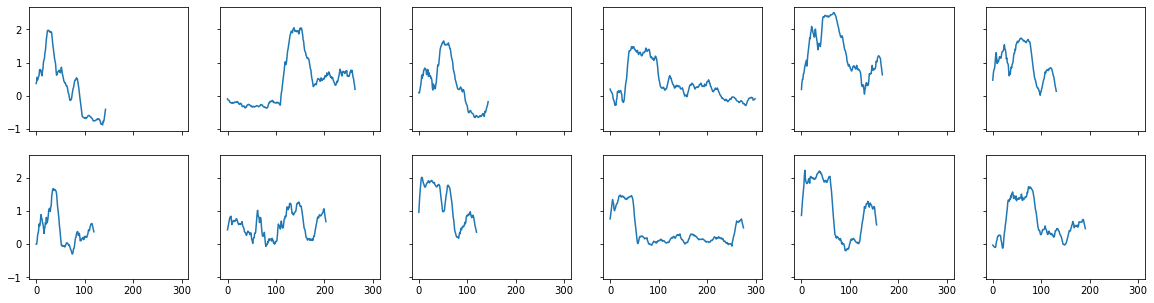

In [33]:
from matplotlib import pyplot as plt
samples = 6
dsets = [train_dset.pos_dset, train_dset.neg_dset]#, valid_dset.pos_dset,  valid_dset.neg_dset]
fig, axs = plt.subplots(len(dsets),samples, sharey=True, sharex=True, figsize=(20,5))
for i in range(samples):
    for j,d in enumerate(dsets):
        axs[j][i].plot(next(d)[0])



In [27]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import accuracy_score
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KernelKMeans
import numpy as np
#TODO try without padding
dsets = [train_dset.pos_dset, train_dset.neg_dset]#, valid_dset.pos_dset,  valid_dset.neg_dset]
X = []
y = []
for dset in dsets:
    for _ in range(10000):
        sig, lab = next(dset)
        X.append(sig)
        y.append(lab)
num_of_cl = 2
X = to_time_series_dataset(X)


In [32]:
clf = TimeSeriesKMeans(n_clusters=num_of_cl, max_iter=30, metric='euclidean', verbose=0, n_jobs=10)
# clf = KernelKMeans(n_clusters=num_of_cl, max_iter=5)
clf.fit(X)
# accuracy_score(y,clf.predict(X))
labels = clf.predict(X)
y = np.array(y)

for cluster in range(num_of_cl):
    cluster_indices = np.where(labels == cluster)[0]
    cluster_labels = y[cluster_indices]
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster {cluster}: {len(cluster_indices)} data points")
    if(len(counts) > 0):
        print(' -',round(counts[0]/sum(counts),2), 'ratio of negatives')
    for label, count in zip(unique_labels, counts):
        print(f" - {count} data points with class label {int(label)}")

Cluster 0: 20000 data points
 - 0.5 ratio of negatives
 - 10000 data points with class label 0
 - 10000 data points with class label 1
Cluster 1: 0 data points
